In [1]:
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2Motif')
dataset = dataset.shuffle()


In [165]:
import ot
import networkx as nx
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, coalesce
import numpy as np
import torch
from torch_geometric.data import Data
import random

def filter_undirected_edges(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.size(1)):
        u, v = sorted(edge_index[:, i].tolist()) 
        edge = (u, v)
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])
    
    return torch.tensor(unique_edges, dtype=torch.long).T 

def ensure_undirected(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i].tolist()
        edge = tuple(sorted((u, v)))
        
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])

    bidirectional_edges = []
    for u, v in unique_edges:
        bidirectional_edges.append([u, v])
        bidirectional_edges.append([v, u])
    
    return torch.tensor(bidirectional_edges, dtype=torch.long).T

def pyg_to_fgw_format(graph):
    graph.edge_index = ensure_undirected(graph.edge_index)
    adj = to_dense_adj(graph.edge_index)[0].numpy()
    features = graph.x.numpy()
    p = np.ones(graph.num_nodes) / graph.num_nodes
    
    return adj, features, p

def compute_fgw_distance(graph1, graph2, alpha=0.5):
    # clone graphs
    graph1 = graph1.clone()
    graph2 = graph2.clone()
    C1, features1, p = pyg_to_fgw_format(graph1)
    C2, features2, q = pyg_to_fgw_format(graph2)
    max_nodes = max(features1.shape[0], features2.shape[0])

    # Padding f
    features1 = np.pad(features1, ((0, max_nodes - features1.shape[0]), (0, 0)), mode='constant')
    features2 = np.pad(features2, ((0, max_nodes - features2.shape[0]), (0, 0)), mode='constant')

    C1 = np.pad(C1, ((0, max_nodes - C1.shape[0]), (0, max_nodes - C1.shape[1])), mode='constant')
    C2 = np.pad(C2, ((0, max_nodes - C2.shape[0]), (0, max_nodes - C2.shape[1])), mode='constant')
    
    features1 = features1 / (np.linalg.norm(features1, axis=1, keepdims=True) + 1e-10)
    features2 = features2 / (np.linalg.norm(features2, axis=1, keepdims=True) + 1e-10)
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    M = ot.dist(features1, features2)  
    
    fgw_dist = ot.gromov.fused_gromov_wasserstein2(
        M, C1, C2, p,p,
        loss_fun='square_loss', alpha=alpha
    )
    
    return fgw_dist

In [161]:
graph1 = dataset[4]
graph2 = dataset[4]
graph1 = Data(x=graph1.x, edge_index=filter_undirected_edges(graph1.edge_index))
graph2 = Data(x=graph2.x, edge_index=filter_undirected_edges(graph2.edge_index))
dist = compute_fgw_distance(graph1, graph2, alpha=0.5)
print("Distance:", dist)

[[0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

In [3]:
from model.gin import GIN
from torch_geometric.data import DataLoader
import torch
import random
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)

model.load_state_dict(torch.load('model/model.pth'))
model.eval()

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(10, 32, 32))
    (1-4): 4 x GINConv(nn=MLP(32, 32, 32))
  )
  (mlp): MLP(32, 32, 2)
)

In [ ]:
import random
import torch
from torch_geometric.data import Data

class GraphGenome:
    def __init__(self, data):
        self.num_nodes = data.num_nodes
        self.x = data.x.clone()
        self.edge_index = data.edge_index.clone()
        self.innovation_numbers = {tuple(edge.tolist()): i for i, edge in enumerate(self.edge_index.T)}
        self.fitness = 0
    
    def clone(self):
        return GraphGenome(Data(x=self.x.clone(), edge_index=self.edge_index.clone()))
    
    def eval_fitness_sso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self, alpha=0.5)
        similarity = 0.0 if similarity >= 1 else similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_sdo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self, alpha=0.5)
        similarity = 0.0 if similarity >= 1 else similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_dso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self, alpha=0.5)
        similarity = 0.0 if similarity <= 0.9788 else 1 - similarity
         
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_ddo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self, alpha=0.5)
        similarity = 0.0 if similarity <= 0.9788 else 1 - similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def mutate(self, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        edge_list = set(tuple(edge.tolist()) for edge in self.edge_index.T)
        num_nodes = self.x.size(0)
        
        if random.random() <= 0.5 or len(edge_list) < 15:  # Add edge
            u, v = random.sample(range(num_nodes), 2)
            edge = (u, v) if u < v else (v, u)
            if edge not in edge_list:
                edge_list.add(edge)
                self.innovation_numbers[edge] = len(self.innovation_numbers) + 1
        else:  # Remove edge
            if edge_list:
                edge = random.choice(list(edge_list))
                edge_list.remove(edge)
                self.innovation_numbers.pop(edge, None)
            
                
        new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T
        new_x = self.x.clone()
        mutation_rate = 0.1
        for i in range(num_nodes):
            if random.random() < mutation_rate:
                noise = torch.randn_like(new_x[i]) * 0.05
                new_x[i] = torch.clamp(new_x[i] + noise, 0, 1)
        
        mutated_graph = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        # Evaluate fitness based on case type
        if case_type == 'sso':
            mutated_graph.fitness = mutated_graph.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            mutated_graph.fitness = mutated_graph.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            mutated_graph.fitness = mutated_graph.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:  # 'ddo'
            mutated_graph.fitness = mutated_graph.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)
            
        return mutated_graph
    
    def crossover(self, other, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        parent1_edges = list(set(tuple(edge.tolist()) for edge in self.edge_index.T))
        parent2_edges = list(set(tuple(edge.tolist()) for edge in other.edge_index.T))

        if len(parent1_edges) < 2 or len(parent2_edges) < 2:
            return self  
        cut1, cut2 = sorted(random.sample(range(len(parent1_edges)), 2))

        child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]
        child_edges = list(set(child_edges)) 
        
        new_edge_index = torch.tensor(child_edges, dtype=torch.long).T

        new_x = self.x.clone()
        for i in range(self.x.size(0)):
            new_x[i] = (self.x[i] + other.x[i]) / 2 if random.random() < 0.5 else other.x[i]

        child = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        child.innovation_numbers = {edge: i for i, edge in enumerate(child_edges)}
        
        # Evaluate fitness based on case type
        if case_type == 'sso':
            child.fitness = child.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            child.fitness = child.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            child.fitness = child.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:  # 'ddo'
            child.fitness = child.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)

        return child


def initialize_population(size, graph, blackbox, distance_function, alpha1, alpha2, case_type):
    population = [GraphGenome(graph) for _ in range(size)]
    for individual in population:
        if case_type == 'sso':
            individual.fitness = individual.eval_fitness_sso(graph, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            individual.fitness = individual.eval_fitness_sdo(graph, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            individual.fitness = individual.eval_fitness_dso(graph, blackbox, distance_function, alpha1, alpha2)
        else:  # 'ddo'
            individual.fitness = individual.eval_fitness_ddo(graph, blackbox, distance_function, alpha1, alpha2)
            
    return population

def select_parents(population, ratio):
    population.sort(key=lambda individual: individual.fitness, reverse=True)
    return population[:int(ratio * len(population))]

def genetic_algorithm(graphX, populationSize, generations, blackbox, distance_function, alpha1, alpha2):
    case_population_size = populationSize // 4
    case_type = ['sso', 'sdo', 'dso', 'ddo']
    populations = {}
        
    
    # Initialize populations for both cases
    for type in case_type:
        populations[type] = initialize_population(
                    case_population_size, graphX, blackbox, distance_function, alpha1, alpha2, case_type
                )
        for gen in range(generations):
            print(f"\n===== {type} : Generation {gen+1}/{generations} =====")
            new_population = []
            best_individuals = select_parents(populations[type], 0.4)
            new_population.extend(best_individuals[:len(best_individuals) // 2])
            while len(new_population) < case_population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                child = parent1.crossover(parent2, graphX, blackbox, distance_function, alpha1, alpha2, type)
                if random.random() < 0.2:
                    child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type)
                new_population.append(child)
                    
            populations[type] = new_population
            
    final_population = []
    for population in populations.values():
        final_population.extend(population)
        
    return final_population

In [175]:
graphX = dataset[3]
graphX = Data(x=graphX.x, edge_index=filter_undirected_edges(graphX.edge_index))
print("Graph X:", graphX.edge_index.T.tolist())

final_population = genetic_algorithm(graphX = graphX, populationSize=400, generations=10, blackbox=model, 
                                     distance_function=compute_fgw_distance, 
                                     alpha1=0.5, alpha2=0.5)


Graph X: [[0, 1], [0, 2], [0, 6], [0, 20], [1, 11], [1, 19], [2, 3], [2, 4], [2, 5], [2, 7], [2, 8], [2, 9], [2, 12], [2, 13], [2, 18], [5, 14], [6, 10], [6, 16], [11, 17], [12, 15], [20, 21], [20, 23], [20, 24], [21, 22], [21, 24], [22, 23]]
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009600000000000053 -- evaluation:  0.0
record_similarity:  0.009

Fitness: 0.9986409680366516


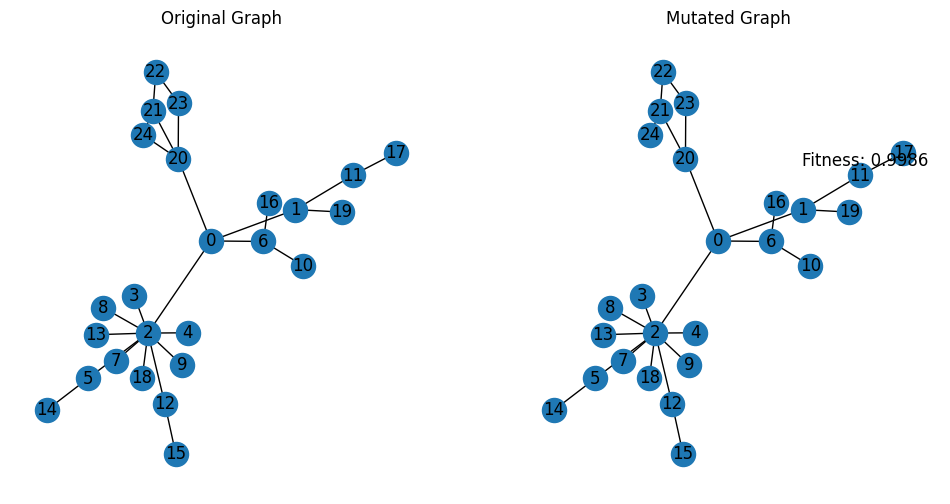

In [198]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

index = random.randint(0, len(final_population) - 1)
print("Fitness:", final_population[index].fitness)
graph_neig = Data(x=final_population[index].x, edge_index=final_population[index].edge_index)

def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Graph")
G_original = to_networkx(graphX, to_undirected=True)
pos = layout(G_original)  
nx.draw(G_original, with_labels=True, pos=pos)

plt.subplot(122)
plt.title("Mutated Graph")
plt.text(0.5, 0.5, "Fitness: {:.4f}".format(final_population[index].fitness), fontsize=12)
G_mutated = to_networkx(graph_neig, to_undirected=True)
nx.draw(G_mutated, with_labels=True, pos=pos)
plt.show()

In [ ]:
import pandas as pd
def compare_graphs(graph1, graph2):
    edges1 = set(map(tuple, graph1.edge_index.T.tolist()))
    print("Edges1:", edges1)
    edges2 = set(map(tuple, graph2.edge_index.T.tolist()))
    print("Edges2:", edges2)
    
    common_edges = edges1 & edges2
    unique_to_g1 = edges1 - edges2
    unique_to_g2 = edges2 - edges1

compare_graphs(graphX, graph_neig)

Edges1: {(20, 23), (21, 22), (22, 23), (0, 2), (2, 5), (11, 17), (2, 8), (0, 20), (12, 15), (21, 24), (0, 1), (2, 4), (2, 7), (1, 11), (2, 13), (6, 10), (6, 16), (20, 21), (20, 24), (5, 14), (0, 6), (2, 3), (2, 9), (2, 12), (2, 18), (1, 19)}
Edges2: {(20, 23), (21, 22), (22, 23), (0, 2), (2, 5), (11, 17), (2, 8), (0, 20), (12, 15), (21, 24), (0, 1), (2, 4), (2, 7), (1, 11), (2, 13), (6, 10), (6, 16), (20, 21), (20, 24), (0, 6), (2, 3), (2, 9), (2, 12), (1, 19)}
diff: 0.0
Difference in p and q: 0.0
M matrix sum: 0.0
Distance: 0.012799999999999999


In [518]:
print(dataset[2].edge_index)
edge_index = filter_undirected_edges(dataset[2].edge_index)
full_edge_index = ensure_undirected(edge_index)
print(full_edge_index)
pred_data = Data(x= dataset[2].x, edge_index=ensure_undirected(edge_index))
pred = model.predict(pred_data.x, pred_data.edge_index, None, 1)
pred

tensor([[ 0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  4,
          4,  5,  5,  6,  6,  7,  7,  8,  9,  9, 10, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1, 20,  0,  2,  3,  5, 10, 12, 14, 16,  1,  4,  6,  8, 13,  1, 19,  2,
          7,  1, 17,  2, 18,  4,  9,  2,  7, 11,  1, 15,  9,  1,  2,  1, 10,  1,
          5,  6,  3,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([[ 0,  1,  0, 20,  1,  2,  1,  3,  1,  5,  1, 10,  1, 12,  1, 14,  1, 16,
          2,  4,  2,  6,  2,  8,  2, 13,  3, 19,  4,  7,  5, 17,  6, 18,  7,  9,
          9, 11, 10, 15, 20, 21, 20, 23, 20, 24, 21, 22, 21, 24, 22, 23],
        [ 1,  0, 20,  0,  2,  1,  3,  1,  5,  1, 10,  1, 12,  1, 14,  1, 16,  1,
          4,  2,  6,  2,  8,  2, 13,  2, 19,  3,  7,  4, 17,  5, 18,  6,  9,  7,
         11,  9, 15, 10, 21, 20, 23, 20, 24, 20, 22, 21, 24, 21, 23, 22]])


tensor([1])

In [176]:
import pandas as pd
import torch
import numpy as np

def create_adjacency_matrix(edge_index, num_nodes):
    """Create an adjacency matrix from edge indices."""
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)
    if edge_index.numel() > 0:  # Check if there are any edges
        for i in range(edge_index.size(1)):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            adj_matrix[src, dst] = 1
            adj_matrix[dst, src] = 1  # Ensure undirected graph
    return adj_matrix

def prepare_dataframe(list_graph, model, device, predict = False):
    all_embeddings = []
    edge_dicts = []
    labels = []
    
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for graph in list_graph:
            x = graph.x.to(device)
            edge_index = ensure_undirected(graph.edge_index).to(device)

            _, node_embeddings = model(x, edge_index, None, 1, return_embeddings=True)

            mean_node_embedding = node_embeddings.mean(dim=1).cpu().numpy()
            all_embeddings.append(mean_node_embedding.tolist())
            
            num_nodes = graph.num_nodes
            adj_matrix = create_adjacency_matrix(graph.edge_index.cpu(), num_nodes)
            
            # Convert adjacency matrix to dictionary
            edge_dict = {f'n{r}_n{c}': adj_matrix[r, c].item() 
                         for r in range(num_nodes) for c in range(r, num_nodes)}
            edge_dicts.append(edge_dict)
            
            if predict:
                labels.append(graph.y.item())
            else :
                prediction = model.predict(x, edge_index, None, 1)
                labels.append(prediction.item())
                
    
    # Create DataFrame
    max_embed_dim = max(len(embed) for embed in all_embeddings)
    embed_columns = [f'nE_{i+1}' for i in range(max_embed_dim)]
    df_embeddings = pd.DataFrame(all_embeddings, columns=embed_columns)
    
    # Create DataFrame for edge information
    df_edges = pd.DataFrame(edge_dicts).fillna(0).astype(int)
    
    # Combine DataFrames
    result_df = pd.concat([df_embeddings, df_edges], axis=1)
    result_df['y'] = labels
    
    return result_df

# Usage example
# Assuming you have already run the genetic algorithm and have final_population

df = prepare_dataframe(final_population, model, device)


In [177]:
# count number of row has y = 1
class_1 = df[df['y'] == 1].shape[0]
class_0 = df[df['y'] == 0].shape[0]
class_1, class_0


(206, 194)

In [17]:
df[:5]

,nE_1,nE_2,nE_3,nE_4,nE_5,nE_6,nE_7,nE_8,nE_9,nE_10,...,n21_n22,n21_n23,n21_n24,n22_n22,n22_n23,n22_n24,n23_n23,n23_n24,n24_n24,y
0,0.010545,0.000000,0.010545,0.010545,0.010547,0.010545,0.010534,0.500197,0.011125,0.027119,...,1,0,0,0,1,0,0,1,0,1
1,0.009375,0.000000,0.009364,0.009375,0.009376,0.135942,0.009371,0.005304,0.010175,0.035724,...,1,0,0,0,1,0,0,1,0,1
2,0.035724,0.002413,0.014066,0.014061,0.035723,0.010392,0.014065,0.010195,0.015126,0.029926,...,1,0,1,0,1,0,0,0,0,1
3,0.035723,0.000000,0.009031,0.009044,0.073437,0.009042,0.004259,0.005288,0.010262,0.024677,...,1,0,0,0,1,0,0,1,0,1
4,0.013448,0.012410,0.035720,0.013413,0.013448,0.367619,0.309801,0.007117,0.002213,0.018271,...,1,0,0,0,1,0,0,1,0,1


In [18]:
df.to_pickle("generate_sample.pkl")

In [43]:
df_loaded = pd.read_pickle("generate_sample.pkl")
df_loaded.shape


(200, 351)

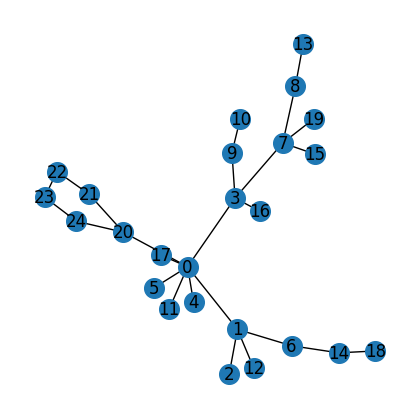

In [99]:
import pickle
def load_graphs_from_pickle(filename = "graph2X.pkl"):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_graphs = load_graphs_from_pickle("graph2X.pkl")
G = to_networkx(loaded_graphs, to_undirected=True)
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, cmap="coolwarm", node_size=200)
plt.show()